In [1]:
import numpy as np
import pylab as plt
import scipy as scp
import igraph as igraph

In [2]:
from jax import jit,grad

import jax.numpy as jnp
import jax.scipy as jscp

In [3]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


In [4]:
from jax import random
from numpyro.infer import MCMC, NUTS

import numpyro
import numpyro.distributions as dist


In [6]:
n = 500

x = np.random.normal(0,1,[n,1])

Dist= (x-x.T)

tau = 1
h = 0.25
r = 2

Cov = tau* (np.exp(- Dist**2/2/h)+ np.eye(n)*1E-7)

Lcov = np.linalg.cholesky(Cov)

In [7]:
z = Lcov@np.random.normal(0,1,[n])

In [8]:
y = np.random.negative_binomial(r,np.exp(z)/(1+np.exp(z)))

In [9]:
from polyagamma import random_polyagamma

In [10]:
def updateZ(z,Cov,r):
    # draw polya-gamma
    omega = random_polyagamma(y+r,np.array(z))

    # draw latent z
    k = r- (y+r)/2

    Sigma_z_full_cond =  np.linalg.inv(np.linalg.inv( Cov) + np.diag(omega)) + np.eye(n)*1E-7

    mu_z_full_cond = Sigma_z_full_cond@k

    z = mu_z_full_cond + np.linalg.cholesky(Sigma_z_full_cond)@ np.random.normal(0,1,n)

    return z

In [11]:
def softplus(x):
    return np.log1p(np.exp(x))

In [12]:
def logDensity_mh(h_tau_unsigned,z,tau):
    h = np.abs(h_tau_unsigned[0])
    r = np.abs(h_tau_unsigned[1])

    Cov_tilde = ( np.exp(- Dist**2/2/h)+ np.eye(n)*1E-7)
    z_den = -(n/2+2) * np.log(z.T@np.linalg.solve(Cov_tilde,z)/2.0 +1.0) - np.linalg.slogdet(Cov_tilde)[1]/2.0
    y_den = (r* z - (y+r)* softplus(z)).sum() + (scp.special.loggamma(r+y)- scp.special.loggamma(r)).sum()
    prior_den =  - 3* np.log(h) - 1.0/h - (r**2)/2.0
    
    return z_den+ y_den + prior_den
    

In [13]:
h_tau_unsigned = np.array([h,r])

In [14]:
def randomWalkMetropolis_h_r(theta,z,tau, s = 1):
    # canonical random-walk Metropolis

    curLogpost = logDensity_mh(theta,z,tau)
    theta_star = theta + np.random.uniform(-1,1,[2])*s #np.random.normal(0,1,[p])*s
    propLogpost = logDensity_mh(theta_star,z,tau)
    accept = 0
    if np.log(np.random.uniform(0,1,1))<(propLogpost - curLogpost):
        theta = theta_star
        accept =1
    return (theta,accept)

In [15]:
from tqdm.notebook import tqdm

In [16]:
trace_z = []
trace_h_tau_unsigned = []
mh_accept = 0

rw_s = 1E-1
burnin = 0.2
iters = 2000

for step in tqdm(range(iters)):
    z = updateZ(z,Cov,r)
    
    h_tau_unsigned,accept = randomWalkMetropolis_h_r(h_tau_unsigned,z,tau,s=rw_s)
    h = np.abs(h_tau_unsigned[0])
    r = np.abs(h_tau_unsigned[1])
    
    Cov = tau* ( np.exp(- Dist**2/2/h)+ np.eye(n)*1E-7)
    mh_accept +=accept

    tau = 1/ np.random.gamma(n/2+ 2, 1.0/ (z@np.linalg.solve( Cov/tau ,z)/2+ 1),1)

    if step> (iters*burnin):
    
        trace_z.append(z)
        trace_h_tau_unsigned.append(np.concatenate([h_tau_unsigned,tau]))
    
print(mh_accept/iters)

  0%|          | 0/2000 [00:00<?, ?it/s]

0.3485


In [17]:
h

0.6015124681133576

In [18]:
trace_h_tau = np.abs(np.vstack(trace_h_tau_unsigned))

In [19]:
trace_z = np.vstack(trace_z)

In [20]:
import arviz


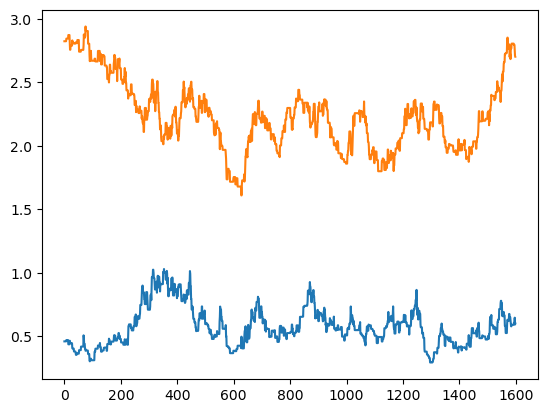

In [21]:
plt.plot(trace_h_tau[:,0])
plt.plot(trace_h_tau[:,1])
# plt.plot(trace_h_tau[:,2])

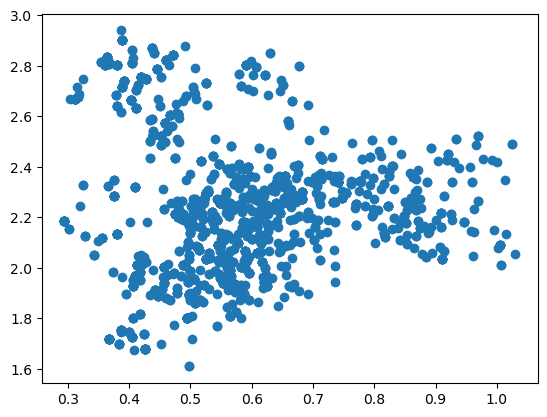

In [22]:
plt.scatter(trace_h_tau[:,0],trace_h_tau[:,1])

In [24]:
# here starts the acceleration

In [25]:
def logDensity0(theta):

    z = theta[:n]
    h_tau_unsigned = theta[n:]
    
    h = jnp.abs(h_tau_unsigned[0])
    r = jnp.abs(h_tau_unsigned[1])
    tau = jnp.abs(h_tau_unsigned[2])

    Cov = tau* (jnp.exp(- Dist**2/2/h)+ jnp.eye(n)*1E-7)
    z_den = - z.T@jnp.linalg.solve(Cov,z)/2.0 - jnp.linalg.slogdet(Cov)[1]/2.0
    y_den = (r* z - (y+r)* jnp.log1p(jnp.exp(z))).sum()  + (jscp.special.gammaln(r+y)- jscp.special.gammaln(r)).sum()
    prior_den =  - 3* jnp.log(h)- 1.0/h - (r**2)/2.0
    
    return z_den+ y_den + prior_den

logDensity = jit(logDensity0)

    

In [26]:
beta  = jnp.hstack([trace_z, trace_h_tau])

In [27]:
m,p = beta.shape

In [28]:
def loss(theta):
    return - logDensity(theta)

U = jit(loss)

grad_U = jit(grad(U))

In [29]:
beta_mean = beta.mean(0)
beta_sd = np.array(beta.std(0))

In [30]:
cdist = scp.spatial.distance.cdist

In [31]:
cov_beta = np.cov(beta.T)
VI = np.linalg.inv(cov_beta + np.eye(p)* 1E-3)
VI = jnp.array(VI)
V_diag =  VI.diagonal()

In [32]:
def dist_func(a,b):
    return cdist(a,b,  'seuclidean',V= V_diag)
    # return cdist(a,b, 'mahalanobis',VI= VI)

In [33]:
J = beta.shape[0]

logDensityBeta = np.array([logDensity(beta[i]) for i in range(beta.shape[0])]).reshape([J,1])

distLogDensityBeta= cdist(logDensityBeta,logDensityBeta)

distBeta= dist_func(beta,beta)

kappa = 1

Graph_weights = (distLogDensityBeta< kappa)* kappa  / (1+distBeta)  +  (distLogDensityBeta> kappa)* distLogDensityBeta

In [34]:
import igraph as ig

In [35]:
G0= ig.Graph().Weighted_Adjacency(np.array(Graph_weights),mode='undirected',loops=False)

weight = [w for w in G0.es["weight"]]

G = G0.spanning_tree(weights=weight)

In [36]:
A_G = np.array(list(G.get_adjacency()))
 

In [37]:
plt.rcParams.update({'font.size': 22})

In [39]:
def projToBetaJ(theta):
    return  dist_func(beta,np.array([theta])).argmin()

In [40]:
mass = np.ones(p)

In [41]:
import scipy.optimize as opt

In [42]:
Bisection = scp.optimize.bisect
def findProjInterval(x,v,w=1.0, l= 1E5):
    
    j = projToBetaJ(x)
    
    def f(z):
        return np.abs(projToBetaJ(x+ z*v) - j)-0.1 #make it slightly below zero
    
    w_l = -w
    w_r = +w

    while f(w_l) < 0 and (-w_l)< l:
            w_l*=2
    while f(w_r) < 0 and w_r< l:
            w_r*=2


            
    if w_l == -w:
        w_l_half =0
    else:
        w_l_half = w_l/2.0

    if w_r == w:
        w_r_half =0
    else:
        w_r_half = w_r/2.0
    
    if (-w_l) < l:
        lb = Bisection(f,w_l,w_l_half,maxiter=1000)
    else:
        lb = -l
    
    if (w_r) < l:
        ub = Bisection(f,w_r_half,w_r,maxiter=1000)
    else:
        ub = l

    return (lb,ub)

              

In [43]:
def runGraphAccMCMC(theta_ini, algo_choice_w=0.5, steps= 10000, burnin = 0.5,
                    s =1, ball_r=1,
                    ball_remove_center=True,
                    proj_dist_limit = 1E5,adaptive_interval = False):

    beta_cov = np.cov(beta.T)
    beta_cov_svd = np.linalg.svd(beta_cov)
    V = beta_cov_svd[0]

    # mass = np.diag(np.cov(beta.T))
    
    mass = np.ones(theta_ini.shape[0])
                        
    theta = theta_ini.copy()
    
    curLogpost = logDensity(theta)

    trace_theta = []
    
    accept_graph_jump = 0

    jump_record = np.repeat(0, int(steps*(1.0-burnin)))
    
    accept_mh = 0
    
    fail_slice_count = 0

    h_tau_unsigned = theta[n:]
    z = theta[:n]
    
    for step in tqdm(range(steps)):
        
        curLogpost = logDensity(theta)


        algo_choice = np.random.uniform(0,1,1)[0]<algo_choice_w

        
        if algo_choice:

            # jump over graph
            j_hat =  projToBetaJ(theta)

            j_hat_ball = G.neighborhood(j_hat,ball_r)
            if ball_remove_center:
                j_hat_ball.remove(j_hat)
                
            # curLogpostBeta = logDensityBeta[j_hat]
            
            j_hat_ball_size = len(j_hat_ball)

            # jump over graph

            
            shift = theta - beta[j_hat]
            cur_s = np.linalg.norm(shift)
            direction = shift / cur_s
            
            
            skip = False
            
            if cur_s > proj_dist_limit:
                skip = True
                theta_prop = theta.copy()
                
            if j_hat_ball_size  ==0:
                skip = True
                theta_prop = theta.copy()
                i = j_hat
            else:
                i = np.random.choice(j_hat_ball ,1)[0]
                
            
            # find two intervals that proj to beta[i] and beta[j_hat]
            (a_j,b_j) = findProjInterval(beta[j_hat],direction,w=0.1, l= proj_dist_limit)            
            (a_i,b_i) = findProjInterval(beta[i],direction,w=0.1, l= proj_dist_limit)

            # propLogpostBeta = logDensity(beta[i])

            theta_prop = beta[i] + np.random.uniform(a_i,b_i) * direction
                
            j_hat_back =  i #projToBetaJ(theta_prop)
            j_hat_back_ball = G.neighborhood(j_hat_back,ball_r)
            if ball_remove_center:
                j_hat_back_ball.remove(j_hat_back)
                    
            j_hat_back_ball_size = len(j_hat_back_ball)
            # if j_hat_back != i:
                # skip = True 
            
            if (not skip):

                        
                propLogpost = logDensity(theta_prop)
                forward_prop =  - np.log(j_hat_ball_size) - np.log(b_i-a_i)
                backward_prop =  - np.log(j_hat_back_ball_size) - np.log(b_j-a_j)
                
                if np.log(np.random.uniform(0,1,1))<(propLogpost + backward_prop) - (curLogpost+forward_prop):
                    theta = theta_prop
                    curLogpost = propLogpost

                    accept_graph_jump+=1

                    if(j_hat_back == i):
                        jump_record[step- int(steps*burnin)]=1

        else:
        
        # if True:

            h_tau_unsigned = theta[n:]
            h = np.abs(h_tau_unsigned[0])
            r = np.abs(h_tau_unsigned[1])
            tau = np.abs(h_tau_unsigned[2])

            delta = h_tau_unsigned[:2]

            rw_s = s * np.random.uniform(0,2)
            
            delta,accept = randomWalkMetropolis_h_r(delta,z,tau,s=rw_s)
            h = np.abs(delta[0])
            r = np.abs(delta[1])
            
            Cov = tau* (np.exp(- Dist**2/2/h)+ np.eye(n)*1E-7)

            tau = 1/ np.random.gamma(n/2+ 2, 1.0/ (z@np.linalg.solve( Cov/tau ,z)/2+ 1),1)

            z = updateZ(z,Cov,r)
            
            accept_mh +=accept

            theta= jnp.concatenate([z,delta,tau])

        if step > (steps* burnin):
            trace_theta.append(theta)
            


    trace_theta =np.vstack(trace_theta)
    
    print(accept_mh/steps )
    print(accept_graph_jump)
    
    return(trace_theta, jump_record)



In [44]:
theta_ini = np.mean(beta,0) #np.zeros([p])
iters = 2000

In [45]:
logDensity(theta_ini)

Array(2713.11542105, dtype=float64)

In [46]:
rw_s = 0.15

In [47]:
s = rw_s

no_acc = runGraphAccMCMC(theta_ini,algo_choice_w=0,steps=iters, 
                                  burnin=0.2,s = s,  ball_r=1)

trace_no_acc = no_acc[0]


  0%|          | 0/2000 [00:00<?, ?it/s]

0.4515
0


In [48]:
algo_choice_w = 0.5

acc = runGraphAccMCMC(theta_ini,algo_choice_w=algo_choice_w,steps=iters, 
                                  burnin=0.2,s = s,  ball_r=3)

trace_acc = acc[0]
jump_record = acc[1]
jump_step_idx = np.arange(len(jump_record))[jump_record==1]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.1835
198


In [49]:
ess = [arviz.ess(np.array(trace_no_acc[:,i]))/np.shape(trace_no_acc)[0] for i in range(n)]

np.mean(ess),np.quantile(ess,[0.025,0.975])

(0.0111315920512859, array([0.00393917, 0.02170741]))

In [50]:
ess = [arviz.ess(np.array(trace_acc[:,i]))/np.shape(trace_acc)[0] for i in range(n)]

np.mean(ess),np.quantile(ess,[0.025,0.975])

(0.08159159896095418, array([0.04968295, 0.15479295]))

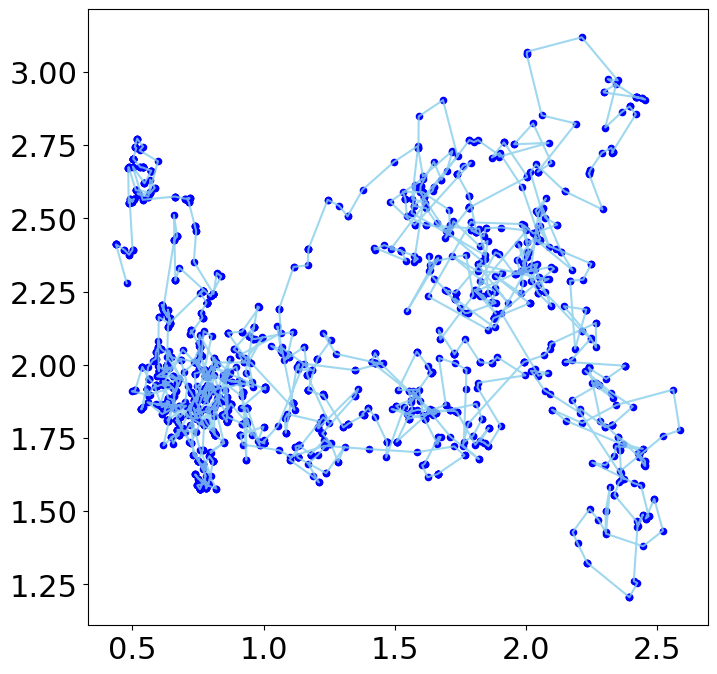

In [51]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.scatter(np.abs(trace_no_acc[:,n]),trace_no_acc[:,n+1],s=20, alpha=1, facecolors='blue')
ax.plot(np.abs(trace_no_acc[:,n]),trace_no_acc[:,n+1],c='skyblue',alpha=0.8)

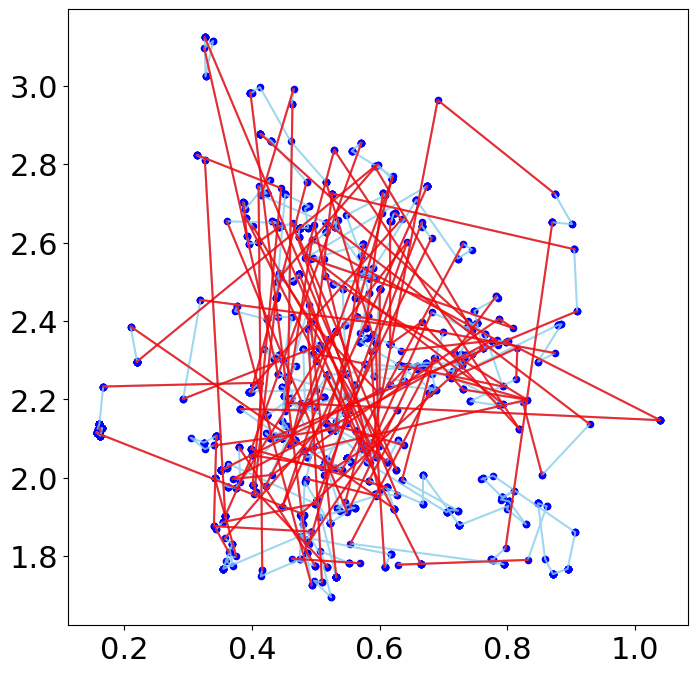

In [52]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.scatter(np.abs(trace_acc[:,n+0]),trace_acc[:,n+1],s=20, alpha=1, facecolors='blue')
ax.plot(np.abs(trace_acc[:,n+0]),trace_acc[:,n+1],c='skyblue',alpha=0.8)
for i in jump_step_idx:
    ax.plot(np.abs(trace_acc[(i-2):(i),n]),trace_acc[(i-2):(i),n+1],c='red',alpha=0.8)
    